In [58]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from scipy import stats
import pystan as stan
import arviz

# Set default figure size
plt.rcParams["figure.figsize"] = (15, 10)
pd.plotting.register_matplotlib_converters()

In [2]:
# Here"s my minute data for the S&P 500
spx_minute = pd.read_csv("SPX_1min.csv", header=0,names=["datetime", "open", "high", "low", "close"],
                                  index_col="datetime", parse_dates=True)

In [3]:
# Here"s the function for calculating the 1-min RV, as discussed in my last post
def rv_calc(data):
    results = {}
    
    for idx, data in data.groupby(data.index.date):
        returns = np.log(data["close"]) - np.log(data["close"].shift(1))
        results[idx] = np.sum(returns**2)
        
    return pd.Series(results)

In [52]:
spx_rv = np.sqrt(rv_calc(spx_minute))

In [34]:
conn = sqlite3.Connection("data.db")
spx_data = pd.read_sql("SELECT * FROM prices WHERE ticker='^GSPC'", conn, index_col="date", parse_dates="date")
spx_returns = np.log(spx_data["close"]) - np.log(spx_data["close"].shift(1))
spx_returns = spx_returns.dropna()

vix_data = pd.read_sql("SELECT * FROM prices WHERE ticker='^VIX'", conn, index_col="date", parse_dates="date")
# This puts it into units of daily standard deviation
vix = vix_data["close"] / np.sqrt(252) / 100

In [195]:
# Get a frame containing all variables and make sure they're all the same length
x = pd.DataFrame({"spx_rv": spx_rv, "spx_returns": spx_returns, "vix": vix}).dropna()
y = spx_rv.rolling(5).sum().shift(-5).dropna()

common_index = x.index.intersection(y.index)
x = x.loc[common_index]
y = y.loc[common_index]

In [199]:
model_spec = '''
data {
    int K;  // Number of lags
    int N;  // Length of data
    int P;  // Number of variables
    matrix[N, P] x;
    vector[N] y;
    int N_tilde;
    matrix[N_tilde, P] x_tilde;
    vector[N_tilde] y_tilde;
}
parameters {
    real mu;
    matrix[K, P] beta;
    real<lower=0> sigma;
}
model {
    mu ~ cauchy(0, 10);
    for (k in 1:K) {
        beta[k] ~ cauchy(0, 10);
    }
    sigma ~ cauchy(0, 5);
    
    for (n in (K+1):N) {
        real alpha = mu;
        for (k in 1:K) {
            alpha += dot_product(beta[k], x[n-k]);
        }
        y[n] ~ normal(alpha, sigma);
    }
}
generated quantities {
    vector[N] is_y_tilde;
    vector[N_tilde] os_y_tilde;
    for (n in (K+1):N) {
        real alpha = mu;
        for (k in 1:K) {
            alpha += dot_product(beta[k], x[n-k]);
        }
        is_y_tilde[n] = normal_rng(alpha, sigma);
    }
    
    for (n in (K+1):N_tilde) {
        real alpha = mu;
        for (k in 1:K) {
            alpha += dot_product(beta[k], x_tilde[n-k]);
        }
        os_y_tilde[n] = normal_rng(alpha, sigma);
    }
}
'''

In [141]:
model = stan.StanModel(model_code=model_spec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b14826ac74ebfc3a2fa1d7305f86779 NOW.


In [200]:
index = int(len(data) * .75)
is_x = x.iloc[:index]
is_y = y.iloc[:index]
os_x = x.iloc[index:]
os_y = y.iloc[index:]

params = {"K": 3, "N": len(is_x), "P": len(is_x.columns), "x": is_x, "y": is_y,
          "N_tilde": len(os_x), "x_tilde": os_x, "y_tilde": os_y}

sample = model.sampling(data=params, chains=4, warmup=250, iter=1500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [201]:
print(sample.stansummary(pars=['mu', 'beta', 'sigma']))

Inference for Stan model: anon_model_2b14826ac74ebfc3a2fa1d7305f86779.
4 chains, each with iter=1500; warmup=250; thin=1; 
post-warmup draws per chain=1250, total post-warmup draws=5000.

             mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu        -2.2e-3  9.6e-6 7.4e-4 -3.6e-3 -2.7e-3 -2.2e-3 -1.7e-3 -7.3e-4   5863    1.0
beta[1,1]    1.04  2.0e-3   0.12    0.81    0.95    1.03    1.12    1.27   3616    1.0
beta[2,1]    0.71  1.9e-3   0.12    0.48    0.63    0.71    0.79    0.96   4016    1.0
beta[3,1]    0.89  2.0e-3   0.12    0.66    0.81    0.89    0.97    1.12   3576    1.0
beta[1,2]   -0.14  6.7e-4   0.04   -0.21   -0.17   -0.14   -0.12   -0.07   3038    1.0
beta[2,2]   -0.12  6.9e-4   0.04    -0.2   -0.15   -0.12    -0.1   -0.05   2985    1.0
beta[3,2]  6.7e-3  3.0e-4   0.02   -0.03 -7.7e-3  6.4e-3    0.02    0.05   4964    1.0
beta[1,3]    1.89  8.3e-3   0.42    1.06    1.61    1.89    2.16    2.72   2550    1.0
beta[2,3]   -0.88    0.01   0

In [202]:
np.mean(sample["beta"], axis=0)

array([[ 1.03518302, -0.14114797,  1.88541685],
       [ 0.71354502, -0.12381969, -0.8780716 ],
       [ 0.8928801 ,  0.00672116,  0.55442168]])

In [203]:
arviz_data = arviz.from_pystan(
    posterior=sample
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

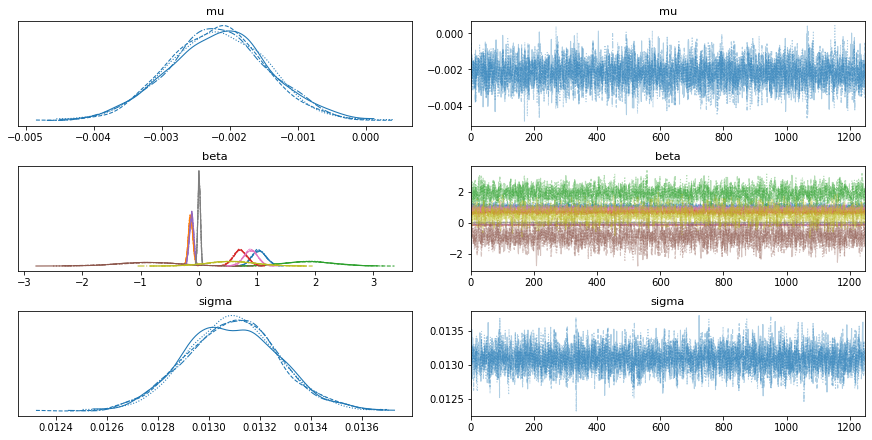

In [204]:
arviz.plot_trace(arviz_data, var_names=['mu', 'beta', 'sigma'])

In [205]:
test = np.mean(sample["os_y_tilde"], axis=0)

In [228]:
test2 = stats.linregress(test[3:], os_y[3:])

In [232]:
test2

LinregressResult(slope=0.931297904092242, intercept=0.002225311368045775, rvalue=0.8188991348220062, pvalue=2.4322348762097972e-209, stderr=0.02227030690807295, intercept_stderr=0.0009699533983621391)